In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Charger les données préparées ===
df = pd.read_csv("../data/processed/eu_ev_by_country_year.csv")

print("Aperçu des données :")
display(df.head())
print("Colonnes :", df.columns.tolist())


Aperçu des données :


,geo,year,BEV,PHEV,HEV,Diesel,Petrol,Other,EV_total,Hybrid_total,All_fuels_total


Colonnes : ['geo', 'year', 'BEV', 'PHEV', 'HEV', 'Diesel', 'Petrol', 'Other', 'EV_total', 'Hybrid_total', 'All_fuels_total']


In [2]:
import pandas as pd
df = pd.read_csv("../data/processed/eu_ev_by_country_year.csv")
print(df.shape)
df.head()


(0, 11)


,geo,year,BEV,PHEV,HEV,Diesel,Petrol,Other,EV_total,Hybrid_total,All_fuels_total


In [3]:
from pathlib import Path

top5 = (df.groupby("geo", as_index=False)["EV_total"].sum()
          .sort_values("EV_total", ascending=False)
          .head(5))
display(top5)

# (optionnel) sauvegarder la table
Path("../data/processed").mkdir(parents=True, exist_ok=True)
top5.to_csv("../data/processed/top5_countries_2015_2023.csv", index=False)


,geo,EV_total


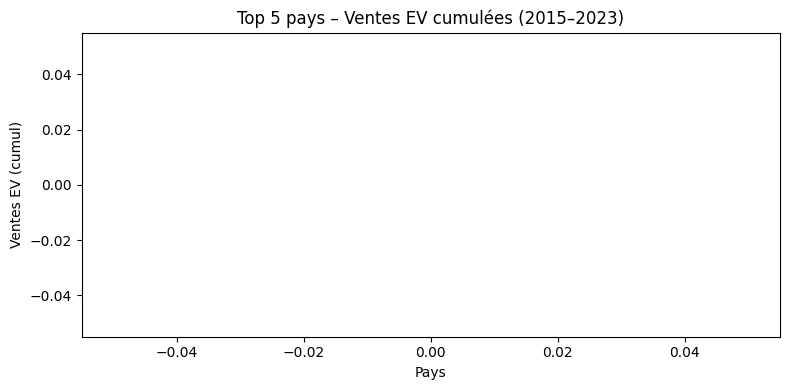

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path

Path("../dashboard").mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,4))
plt.bar(top5["geo"], top5["EV_total"])
plt.title("Top 5 pays – Ventes EV cumulées (2015–2023)")
plt.xlabel("Pays"); plt.ylabel("Ventes EV (cumul)")
plt.tight_layout()
plt.savefig("../dashboard/fig_top5_pays.png", dpi=200, bbox_inches="tight")
plt.show()


In [7]:
import pandas as pd
eu = pd.read_csv("../data/processed/eu_ev_by_country_year.csv")

print("df shape:", eu.shape)
print("Years:", eu["year"].min(), "→", eu["year"].max())
print("BEV total:", eu["BEV"].sum(), " | PHEV total:", eu["PHEV"].sum(), " | EV_total:", eu["EV_total"].sum())

eu_total = eu.groupby("year", as_index=False)[["BEV","PHEV","EV_total"]].sum().sort_values("year")
print(eu_total.head(10))
print(eu_total.tail(10))


df shape: (0, 11)
Years: nan → nan
BEV total: 0  | PHEV total: 0  | EV_total: 0
Empty DataFrame
Columns: [year, BEV, PHEV, EV_total]
Index: []
Empty DataFrame
Columns: [year, BEV, PHEV, EV_total]
Index: []


,year,BEV,PHEV,EV_total


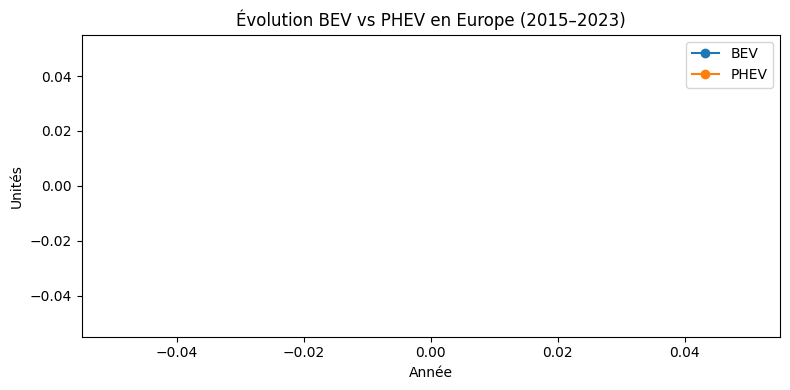

In [5]:
eu_total = df.groupby("year", as_index=False)[["BEV","PHEV","EV_total"]].sum()
display(eu_total.head())

plt.figure(figsize=(8,4))
plt.plot(eu_total["year"], eu_total["BEV"], marker="o", label="BEV")
plt.plot(eu_total["year"], eu_total["PHEV"], marker="o", label="PHEV")
plt.title("Évolution BEV vs PHEV en Europe (2015–2023)")
plt.xlabel("Année"); plt.ylabel("Unités")
plt.legend()
plt.tight_layout()
plt.savefig("../dashboard/fig_bev_phev.png", dpi=200, bbox_inches="tight")
plt.show()


In [6]:
y23 = eu_total.loc[eu_total["year"]==2023, ["BEV","PHEV"]].sum()

plt.figure(figsize=(5,5))
plt.pie(y23, labels=["BEV","PHEV"], autopct="%1.1f%%", startangle=90)
plt.title("Mix EV Europe (2023)")
plt.tight_layout()
plt.savefig("../dashboard/fig_mix_2023.png", dpi=200, bbox_inches="tight")
plt.show()


/Users/ritej/Documents/ev-europe-market/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3368: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 500x500 with 1 Axes>